In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset, random_split
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [5]:
import os
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display

In [6]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt


In [7]:
tracks = pd.read_csv('fma_metadata/tracks.csv', header=[0, 1], index_col=0, low_memory=False)
features = pd.read_csv('fma_metadata/features.csv', header=[0, 1, 2], index_col=0, low_memory=False)


In [8]:
tracks[('set', 'subset')] = tracks[('set', 'subset')].astype(str)
medium = tracks[('set', 'subset')] == 'medium'
train = tracks[('set', 'split')] == 'training'
test = tracks[('set', 'split')] == 'test'
validation = tracks[('set', 'split')] == 'validation'

y_train = tracks.loc[medium & train, ('track', 'genre_top')]
y_val = tracks.loc[medium & validation, ('track', 'genre_top')]
y_test = tracks.loc[medium & test, ('track', 'genre_top')]


In [9]:
genre_to_idx = {genre: idx for idx, genre in enumerate(y_train.unique())}
y_train = y_train.map(genre_to_idx)
y_val = y_val.map(genre_to_idx)
y_test = y_test.map(genre_to_idx)


In [10]:
X_train = features.loc[medium & train, 'mfcc']
X_val = features.loc[medium & validation, 'mfcc']
X_test = features.loc[medium & test, 'mfcc']


In [11]:
class FMA_Dataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        X = self.X.iloc[idx].values.reshape(1, 1, 140)
        y = self.y.iloc[idx]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)


In [12]:
train_dataset = FMA_Dataset(X_train, y_train)
val_dataset = FMA_Dataset(X_val, y_val)
test_dataset = FMA_Dataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [13]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(1, 3))
        self.pool = nn.MaxPool2d((1, 2))
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(1, 3))
        self.fc1 = nn.Linear(32 * 1 * 33, num_classes)
        self.fc2 = nn.Linear(num_classes, num_classes)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [14]:
num_classes = len(y_train.unique())
model = CNN(num_classes=num_classes)


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [16]:
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total


# Trening modela

In [17]:
num_epochs = 10

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_accuracy = calculate_accuracy(train_loader, model)
    
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

    val_accuracy = calculate_accuracy(val_loader, model)

    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_running_loss / len(val_loader))
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy * 100:.4f}, '
          f'Validation Loss: {val_running_loss / len(val_loader):.4f}, '
          f'Validation Accuracy: {val_accuracy * 100:.4f}')
test_accuracy = calculate_accuracy(test_loader, model)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Epoch [1/10], Train Loss: 1.6970, Train Accuracy: 64.7094, Validation Loss: 1.1398, Validation Accuracy: 66.6862
Epoch [2/10], Train Loss: 1.2565, Train Accuracy: 65.8039, Validation Loss: 1.0637, Validation Accuracy: 67.6246
Epoch [3/10], Train Loss: 1.2002, Train Accuracy: 67.7784, Validation Loss: 1.0372, Validation Accuracy: 69.2082
Epoch [4/10], Train Loss: 1.1661, Train Accuracy: 68.3849, Validation Loss: 1.0358, Validation Accuracy: 69.8534
Epoch [5/10], Train Loss: 1.1434, Train Accuracy: 68.6067, Validation Loss: 1.0525, Validation Accuracy: 69.2669
Epoch [6/10], Train Loss: 1.1307, Train Accuracy: 68.3035, Validation Loss: 1.0092, Validation Accuracy: 70.0880
Epoch [7/10], Train Loss: 1.1198, Train Accuracy: 68.5476, Validation Loss: 1.0322, Validation Accuracy: 69.3842
Epoch [8/10], Train Loss: 1.0956, Train Accuracy: 69.7530, Validation Loss: 0.9840, Validation Accuracy: 71.6129
Epoch [9/10], Train Loss: 1.0897, Train Accuracy: 69.3315, Validation Loss: 0.9968, Validation A

# Evaluacija modela


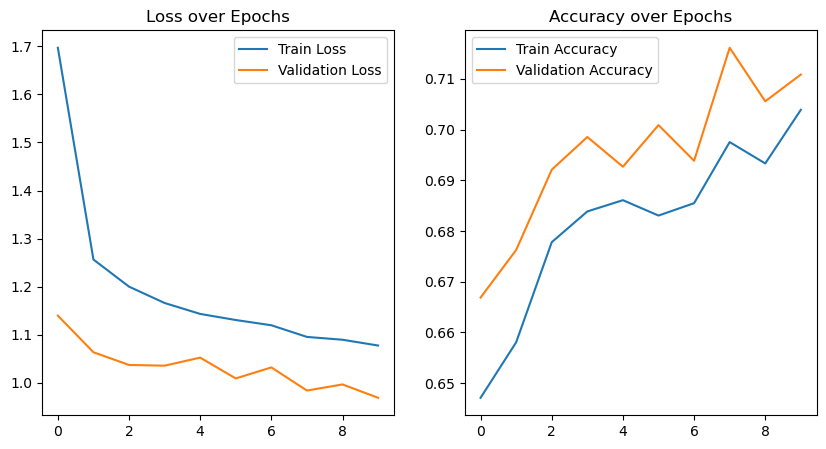

In [18]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()

Training Set Classification Report:
                     precision    recall  f1-score   support

            Hip-Hop       0.66      0.51      0.58       961
               Rock       0.76      0.86      0.81      4881
               Folk       0.73      0.33      0.45       415
               Jazz       0.45      0.19      0.26       306
         Electronic       0.66      0.85      0.74      4250
       Experimental       0.40      0.19      0.26      1001
                Pop       0.00      0.00      0.00       145
             Spoken       0.72      0.28      0.40        94
            Country       1.00      0.01      0.03       142
              Blues       0.00      0.00      0.00        58
Old-Time / Historic       0.97      0.95      0.96       408
           Soul-RnB       0.00      0.00      0.00        94
          Classical       0.77      0.79      0.78       495
       Instrumental       1.00      0.01      0.02       245
      International       1.00      0.21      0.

C:\Users\Q\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Q\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Q\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


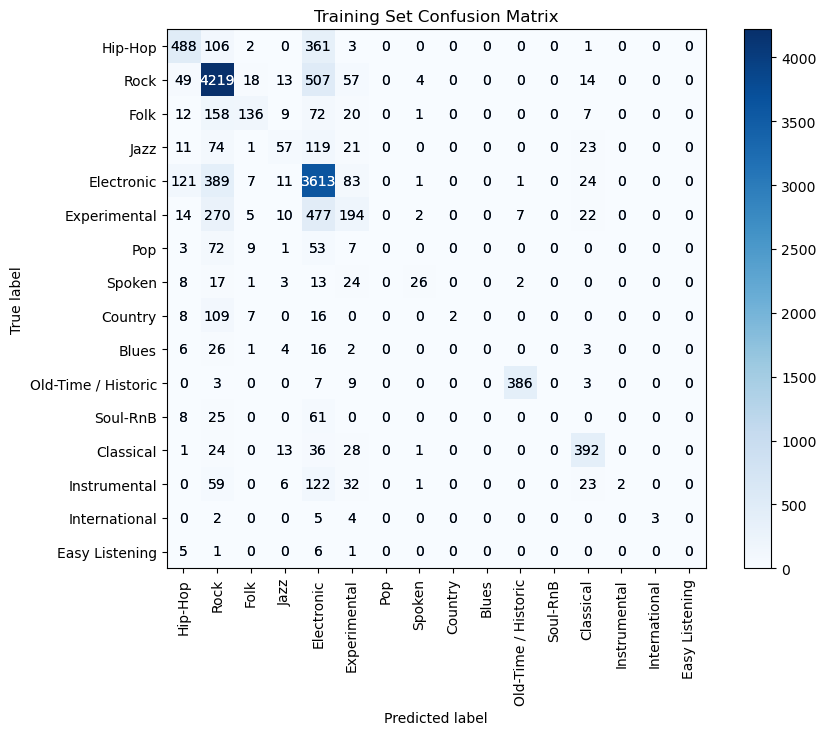

Test Set Classification Report:
                     precision    recall  f1-score   support

            Hip-Hop       0.65      0.47      0.55       120
               Rock       0.74      0.90      0.81       611
               Folk       0.67      0.31      0.42        52
               Jazz       0.50      0.23      0.32        39
         Electronic       0.65      0.88      0.75       532
       Experimental       0.32      0.15      0.21       125
                Pop       0.00      0.00      0.00        19
             Spoken       0.50      0.08      0.14        12
            Country       0.00      0.00      0.00        18
              Blues       0.00      0.00      0.00         8
Old-Time / Historic       0.93      0.98      0.95        51
           Soul-RnB       0.00      0.00      0.00        42
          Classical       0.73      0.82      0.77        62
       Instrumental       0.00      0.00      0.00        74
      International       0.00      0.00      0.00  

C:\Users\Q\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Q\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Q\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


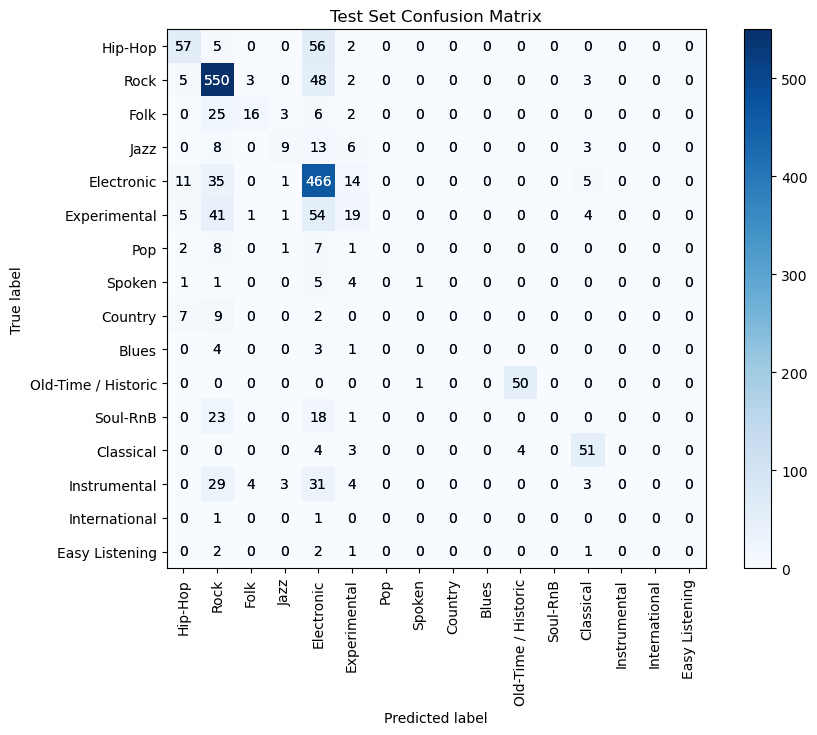

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(loader, model):
    model.eval()
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())
    
    return all_labels, all_predictions


y_train_true, y_train_pred = evaluate_model(train_loader, model)




train_conf_matrix = confusion_matrix(y_train_true, y_train_pred)
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(conf_matrix, title, labels):
    plt.figure(figsize=(10, 7))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
    
    
    disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
    plt.title(title)
    plt.xticks(rotation=90)
    
    
    for (i, j), val in np.ndenumerate(conf_matrix):
        plt.text(j, i, f'{val}', ha='center', va='center', color='white' if val > conf_matrix.max() / 2 else 'black')
    
    plt.show()


y_train_true, y_train_pred = evaluate_model(train_loader, model)


print("Training Set Classification Report:")
print(classification_report(y_train_true, y_train_pred, target_names=list(genre_to_idx.keys())))


train_conf_matrix = confusion_matrix(y_train_true, y_train_pred)
plot_confusion_matrix(train_conf_matrix, 'Training Set Confusion Matrix', list(genre_to_idx.keys()))


y_test_true, y_test_pred = evaluate_model(test_loader, model)


print("Test Set Classification Report:")
print(classification_report(y_test_true, y_test_pred, target_names=list(genre_to_idx.keys())))


test_conf_matrix = confusion_matrix(y_test_true, y_test_pred)
plot_confusion_matrix(test_conf_matrix, 'Test Set Confusion Matrix', list(genre_to_idx.keys()))


In [20]:
import pickle
os.makedirs('final_model', exist_ok=True)
with open('final_model/final.model.pickle','wb') as model_file:
     pickle.dump(model, model_file)


# Model sa drugačijom arhitekturom

Epoch [1/10], Train Loss: 1.3690, Train Accuracy: 63.0010, Validation Loss: 1.1885, Validation Accuracy: 64.9853
Epoch [2/10], Train Loss: 1.2321, Train Accuracy: 63.5409, Validation Loss: 1.1331, Validation Accuracy: 65.7478
Epoch [3/10], Train Loss: 1.1742, Train Accuracy: 66.7357, Validation Loss: 1.0266, Validation Accuracy: 70.1466
Epoch [4/10], Train Loss: 1.1516, Train Accuracy: 67.3717, Validation Loss: 1.0363, Validation Accuracy: 69.6188
Epoch [5/10], Train Loss: 1.1160, Train Accuracy: 66.9280, Validation Loss: 1.0468, Validation Accuracy: 68.2698
Epoch [6/10], Train Loss: 1.0845, Train Accuracy: 67.4161, Validation Loss: 1.0664, Validation Accuracy: 67.3314
Epoch [7/10], Train Loss: 1.0647, Train Accuracy: 67.8968, Validation Loss: 1.0068, Validation Accuracy: 68.6217
Epoch [8/10], Train Loss: 1.0430, Train Accuracy: 69.1540, Validation Loss: 1.0520, Validation Accuracy: 68.8563
Epoch [9/10], Train Loss: 1.0221, Train Accuracy: 70.0118, Validation Loss: 1.0126, Validation A

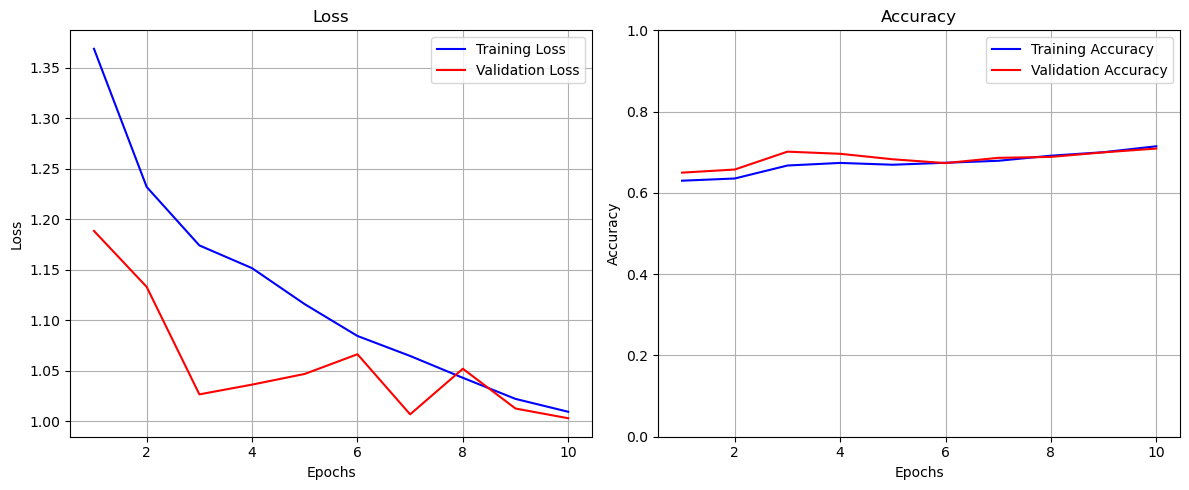

In [33]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt


tracks = pd.read_csv('fma_metadata/tracks.csv', header=[0, 1], index_col=0, low_memory=False)
features = pd.read_csv('fma_metadata/features.csv', header=[0, 1, 2], index_col=0, low_memory=False)

tracks[('set', 'subset')] = tracks[('set', 'subset')].astype(str)
medium = tracks[('set', 'subset')] == 'medium'
train = tracks[('set', 'split')] == 'training'
test = tracks[('set', 'split')] == 'test'
validation = tracks[('set', 'split')] == 'validation'

y_train = tracks.loc[medium & train, ('track', 'genre_top')]
y_val = tracks.loc[medium & validation, ('track', 'genre_top')]
y_test = tracks.loc[medium & test, ('track', 'genre_top')]

genre_to_idx = {genre: idx for idx, genre in enumerate(y_train.unique())}
y_train = y_train.map(genre_to_idx)
y_val = y_val.map(genre_to_idx)
y_test = y_test.map(genre_to_idx)

X_train = features.loc[medium & train, 'mfcc']
X_val = features.loc[medium & validation, 'mfcc']
X_test = features.loc[medium & test, 'mfcc']

class FMA_Dataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
       
        X = self.X.iloc[idx].values.reshape(1, 1, 140)
        y = self.y.iloc[idx]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)


train_dataset = FMA_Dataset(X_train, y_train)
val_dataset = FMA_Dataset(X_val, y_val)
test_dataset = FMA_Dataset(X_test, y_test)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(1, 3)) 
        self.bn1 = nn.BatchNorm2d(32)  
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(1, 3))  
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(1, 3))  
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=(1, 3)) 
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=(1, 3)) 
        self.bn5 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d((1, 2))  

        
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

        
        self._to_linear = None
        self._calculate_linear_input()

        
        self.fc1 = nn.Linear(self._to_linear, 1024)  
        self.fc2 = nn.Linear(1024, 512)  
        self.fc3 = nn.Linear(512, num_classes)  

        self.dropout = nn.Dropout(p=0.3)  

    def _calculate_linear_input(self):
        x = torch.randn(1, 1, 1, 140)  
        x = self.pool(self.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(self.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(self.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool(self.leaky_relu(self.bn4(self.conv4(x))))
        x = self.pool(self.leaky_relu(self.bn5(self.conv5(x))))
        self._to_linear = x.view(1, -1).size(1)

    def forward(self, x):
        x = self.pool(self.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(self.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(self.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool(self.leaky_relu(self.bn4(self.conv4(x))))
        x = self.pool(self.leaky_relu(self.bn5(self.conv5(x))))
        x = x.view(x.size(0), -1)  
        x = self.dropout(self.leaky_relu(self.fc1(x)))
        x = self.dropout(self.leaky_relu(self.fc2(x)))
        x = self.fc3(x)
        return x


num_classes = len(y_train.unique())
model = CNN(num_classes=num_classes)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total


num_epochs = 10

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_accuracy = calculate_accuracy(train_loader, model)
    val_running_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

    val_accuracy = calculate_accuracy(val_loader, model)

    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_running_loss / len(val_loader))
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy * 100:.4f}, '
          f'Validation Loss: {val_running_loss / len(val_loader):.4f}, '
          f'Validation Accuracy: {val_accuracy * 100:.4f}')

test_accuracy = calculate_accuracy(test_loader, model)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


Training Set Classification Report:
                     precision    recall  f1-score   support

            Hip-Hop       0.70      0.54      0.61       961
               Rock       0.79      0.85      0.82      4881
               Folk       0.54      0.52      0.53       415
               Jazz       0.49      0.30      0.37       306
         Electronic       0.66      0.84      0.74      4250
       Experimental       0.47      0.28      0.35      1001
                Pop       0.00      0.00      0.00       145
             Spoken       0.83      0.26      0.39        94
            Country       0.00      0.00      0.00       142
              Blues       0.00      0.00      0.00        58
Old-Time / Historic       0.92      0.98      0.95       408
           Soul-RnB       0.00      0.00      0.00        94
          Classical       0.84      0.77      0.81       495
       Instrumental       0.62      0.03      0.06       245
      International       0.00      0.00      0.

C:\Users\Q\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Q\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Q\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


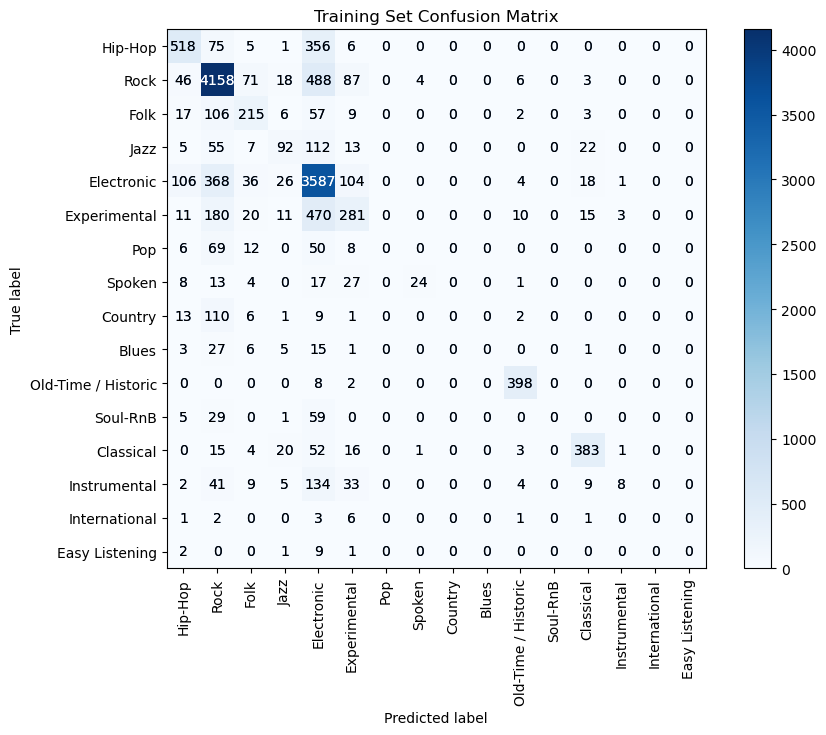

Test Set Classification Report:
                     precision    recall  f1-score   support

            Hip-Hop       0.64      0.52      0.57       120
               Rock       0.78      0.88      0.83       611
               Folk       0.42      0.42      0.42        52
               Jazz       0.53      0.46      0.49        39
         Electronic       0.67      0.86      0.75       532
       Experimental       0.26      0.22      0.23       125
                Pop       0.00      0.00      0.00        19
             Spoken       0.50      0.08      0.14        12
            Country       0.00      0.00      0.00        18
              Blues       0.00      0.00      0.00         8
Old-Time / Historic       0.84      1.00      0.91        51
           Soul-RnB       0.00      0.00      0.00        42
          Classical       0.79      0.60      0.68        62
       Instrumental       0.00      0.00      0.00        74
      International       0.00      0.00      0.00  

C:\Users\Q\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Q\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Q\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


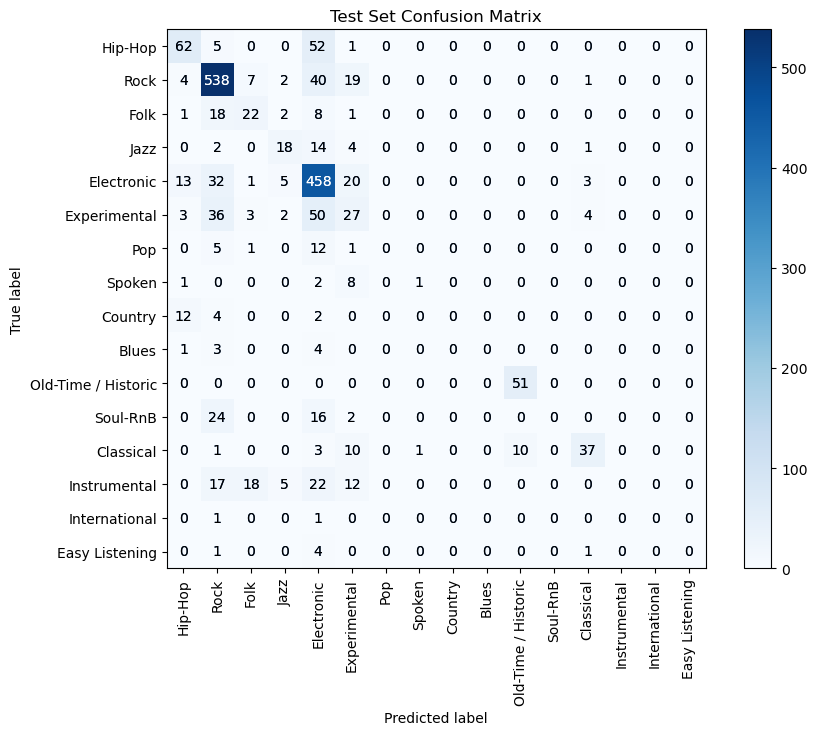

In [34]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(loader, model):
    model.eval()
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())
    
    return all_labels, all_predictions


y_train_true, y_train_pred = evaluate_model(train_loader, model)




train_conf_matrix = confusion_matrix(y_train_true, y_train_pred)
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(conf_matrix, title, labels):
    plt.figure(figsize=(10, 7))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
    
    
    disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
    plt.title(title)
    plt.xticks(rotation=90)
    
    
    for (i, j), val in np.ndenumerate(conf_matrix):
        plt.text(j, i, f'{val}', ha='center', va='center', color='white' if val > conf_matrix.max() / 2 else 'black')
    
    plt.show()


y_train_true, y_train_pred = evaluate_model(train_loader, model)


print("Training Set Classification Report:")
print(classification_report(y_train_true, y_train_pred, target_names=list(genre_to_idx.keys())))


train_conf_matrix = confusion_matrix(y_train_true, y_train_pred)
plot_confusion_matrix(train_conf_matrix, 'Training Set Confusion Matrix', list(genre_to_idx.keys()))


y_test_true, y_test_pred = evaluate_model(test_loader, model)


print("Test Set Classification Report:")
print(classification_report(y_test_true, y_test_pred, target_names=list(genre_to_idx.keys())))


test_conf_matrix = confusion_matrix(y_test_true, y_test_pred)
plot_confusion_matrix(test_conf_matrix, 'Test Set Confusion Matrix', list(genre_to_idx.keys()))


In [35]:
with open('final_model/final.model.pickle2','wb') as model_file:
     pickle.dump(model, model_file)